# Semantic segmentation using Poutyne




Semantic segmentation refers to the process of linking each pixel in an image to a class label. We can think of semantic segmentation as image classification at a pixel level. The image below clarifies the definition of semantic segmentation.
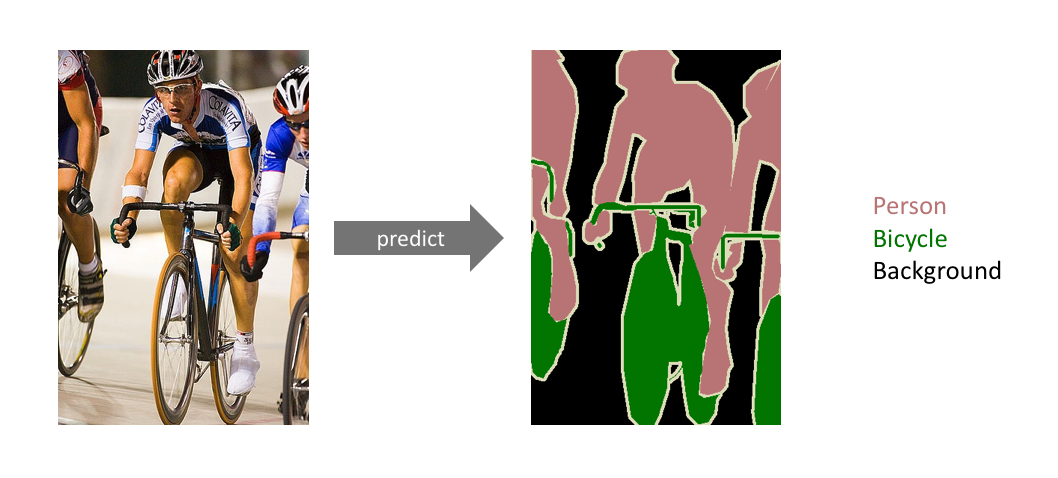

In this example, we are going to use and train a convolutional Unet, in order to design a network for semantic segmentation. In other words, we formulate the task of semantic segmentation as an image translation problem. We download and use the VOCSegmentation 2007 dataset for this purpose.

In [ ]:
%pip install poutyne    # Installing the Poutyne library

Unet (the network we use in this example) is a convolutional neural network, similar to the convolutional autoencoders. However, Unet takes advantage of shortcuts between the encoder (contraction path) and decoder (expanding path), which helps it handle the vanishing gradient problem. In the following sections, we are going to install and import the segmentation-models-PyTorch library, which contains different architectures of Unet.

In [ ]:
%pip install segmentation-models-pytorch 

Let’s import all the needed packages.

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import segmentation_models_pytorch as smp
import PIL
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
import torchvision.models as models
import torchvision.transforms as tfms
import torchvision.datasets as datasets
from torchvision.utils import  make_grid, save_image

from poutyne import Model, ModelCheckpoint, CSVLogger, set_seeds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda


## Training constants

In [21]:
learning_rate = 0.0005
batch_size = 32
image_size = 224
num_epochs = 70
_mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing 
_std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing 
set_seeds(42)


## Loading the VOCSegmentation dataset

The VOCSegmentation dataset can be easily downloaded from `torchvision.datasets`. This dataset allows you, to apply the needed transforms on the ground-truth, directly, in addition to defining the proper transforms for the input images. To do so, it's enough to use the `target_transfrom `argument and set it to your transform function of interest. 

In [12]:
input_transform = tfms.Compose([
    tfms.Resize((image_size, image_size)),  
    tfms.ToTensor(),        
    tfms.Normalize(_mean, _std)
])

target_transform = tfms.Compose([
    tfms.Resize((image_size, image_size)),  
    tfms.ToTensor(),        
])

# Creating the dataset
train_dataset = torchvision.datasets.VOCSegmentation('./dataset/', year='2007', download=True, image_set='train', transform=input_transform, target_transform= target_transform)
valid_dataset = torchvision.datasets.VOCSegmentation('./dataset/', year='2007', download=True, image_set='val', transform=input_transform, target_transform= target_transform )

# Creating the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./dataset/VOCtrainval_06-Nov-2007.tar


## A random batch of the VODSegmentation dataset images

Let's see some of the input samples, inside the training dataset

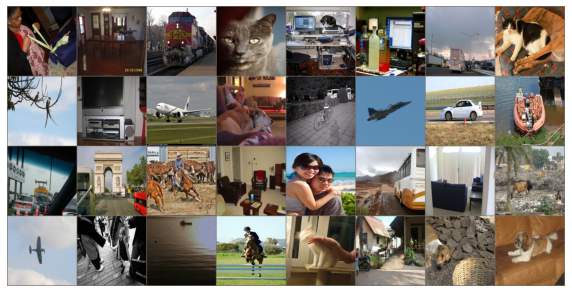

In [28]:
samples = next(iter(train_dataloader))
inputs = samples[0]
input_grid = make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
input_grid = input_grid.numpy()
input_grid = input_grid.transpose((1, 2, 0)) * _std + _mean
inp = np.clip(input_grid, 0, 1)
plt.imshow(inp)
plt.axis('off')
plt.show()

The ground-truth (segmentation map) for the image grid shown above, is as below. 

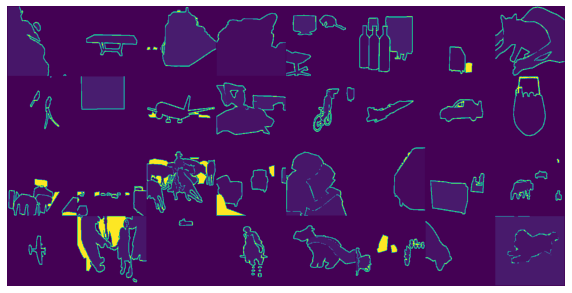

In [29]:
ground_truth = samples[1]
input_grid = make_grid(ground_truth)
inp = input_grid.numpy()[0]

fig = plt.figure(figsize=(10, 10))
plt.imshow(inp)
plt.axis('off')
plt.show()

It is worth mentioning that, as we have approached the segmentation task as an image translation problem, we took advantage of `MSELoss` for the training. Moreover, we believe that using the Unet, with a pre-trained encoder, would help the network converge sooner and better, since a pre-trained CNN (trained on the Imagenet dataset), is already familiar with some of the object classes, and also some low-level image features (such as edge, texture, etc).

In [18]:
# specifying loss function
criterion = nn.MSELoss()

# specifying the network
network = smp.Unet('resnet34', encoder_weights='imagenet')

# specifying optimizer
optimizer = optim.Adam (network.parameters(), lr=learning_rate)

We can see the architecture of the Res34-Unet below. As noticed in the section above, this network is imported from the segmentation-models-PyTorch library, which contains many other architectures as well. You can import and use other available networks, trying to increase the accuracy.

In [36]:
network

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Training deep neural networks is a challenging task, especially when we are dealing with data with big sizes or numbers. There are numerous factors and hyperparameters, which play an important role in the success of the network. One of these determining factors is the epoch number. The right number of epochs would help your network train well, however, the lower and higher numbers would make your network under-fitted or overfitted, respectively. With some types of data (such as images or videos), it is very time-consuming to repeat the training for different numbers of epoch numbers, to find the best one. Poutyne library has provided some fascinating tools to address this problem. As you would notice in the following sections, by the use of <a href="https://poutyne.org/callbacks.html"> callbacks</a>, you would be able to record and retrieve the best parameters (weights) through your rather big number of epochs, without needing to repeat the training process again and again. Moreover, Poutyne also gives you the possibility to resume your training, from the last done epoch, if you feel the need for even more iterations.

In [20]:
#callbacks

save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                    save_best_only=True, restore_best=True, verbose=True),

    # Save the losses for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

## Training

In [ ]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(train_dataloader, valid_dataloader, epochs=num_epochs, callbacks=callbacks, progress_options={'coloring': False})

# Calculation of the scores and visualization of results

There is one more surprising facility in Poutyne, which makes the evaluation task more easy and straight forward. Usually, computer vision researchers try to evaluate their trained networks for validation/test datasets, having the score (accuracy or loss usually), ground_truth, and calculated results simultaneously. The `evaluate` function in Poutyne, not only provides you with the score but also has made the other two items ready for further analysis and visualization. In the next few codes, you will see some examples.

In [23]:
loss, predictions, ground_truth = model.evaluate_generator(valid_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 7 2.15s test_loss: 0.041168                               


We show some of the segmentation results in the image below (grayscale):

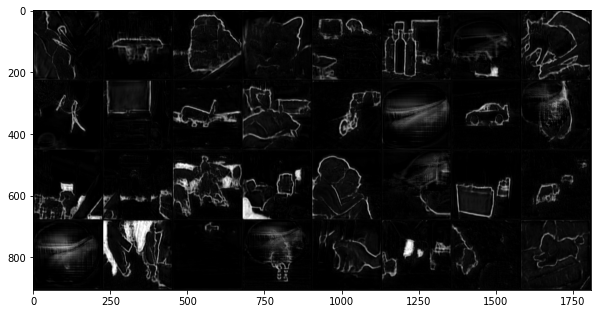

In [30]:
outputs = torch.tensor(model.predict_on_batch(inputs))
output_grid = make_grid(outputs)
out = output_grid.numpy().transpose((1, 2, 0))
out=np.clip(out, 0, 1)

fig = plt.figure(figsize=(10, 10))
plt.imshow((out))
plt.show()

Here, we show one of the input samples, along with its segmentation ground-truth, and the produced output.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


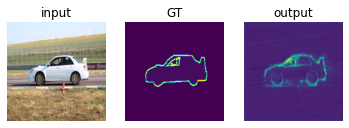

In [35]:
sample_number = 14

input_sample = inputs[sample_number].numpy().transpose((1, 2, 0)) * _std + _mean
ground_truth_sample = ground_truth[sample_number][0]
output_sample = outputs[sample_number][0].numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(input_sample)
ax1.axis('off')
ax1.set_title('input')

ax2.imshow(ground_truth_sample)
ax2.axis('off')
ax2.set_title('GT')

ax3.imshow(output_sample)
ax3.axis('off')
ax3.set_title('output')
plt.show()


# Last note

This example shows you how to simply design and train your own segmentation network, however, to get better results you can play with hyperparameters and do further finetuning to increase the accuracy.